See 'swallow classification bandpass.ipynb' for preprocessing.

In [1]:
import os
import pandas as pd
import random
import shutil

data_path = r'C:\Users\chloe\OneDrive\Desktop\swallow EMG\data\07_18_25\extracted signals'
class_folders = os.listdir(data_path)

# Feature Extraction
I got some of these features and functions from this link: https://www.kaggle.com/code/calulamabel/emg-hand-gesture-classification/notebook

In [2]:
import numpy as np

# mean absolute value
def mav(data):
    return np.mean(np.abs(data), axis=0)

# root mean square
def rms(data):
    return np.sqrt(np.mean(data**2,axis=0))  
    
# wavelength
def wavelength(data):
    return np.sum(np.abs(np.diff(data)), axis=0)
    
# zero crossing rate
def zcr(data):
    return np.sum(np.diff(np.sign(data), axis=0) != 0, axis=0) / (len(data)-1)

# variance
def var(data):
    return np.var(data, axis=0)

# sum of absolute differences between consecutive samples
def abs_diffs_signal(data):
    return np.sum(np.abs(np.diff(data,axis=0)),axis=0)

# mean frequency
def mean_freq(data, fs=500):
    freqs = np.fft.rfftfreq(len(data), d=1/fs)
    spectrum = np.abs(np.fft.rfft(data))**2
    return np.sum(freqs * spectrum) / np.sum(spectrum)

# median frequency
def median_freq(data, fs=500):
    data = data - np.mean(data)
    freqs = np.fft.rfftfreq(len(data), d=1/fs)
    spectrum = np.abs(np.fft.rfft(data))**2
    cumulative = np.cumsum(spectrum)
    total = cumulative[-1]
    med_idx = np.searchsorted(cumulative, total / 2)
    return freqs[med_idx]

# peak frequency
def peak_freq(data, fs=500):
    data = data - np.mean(data)
    freqs = np.fft.rfftfreq(len(data), d=1/fs)
    spectrum = np.abs(np.fft.rfft(data))**2
    peak_idx = np.argmax(spectrum)
    return freqs[peak_idx]

In [3]:
df = pd.DataFrame()

class_map = {}
i = 0

for class_name in os.listdir(data_path):
    if class_name == 'oral prep 0':
        continue
        
    class_path = os.path.join(data_path, class_name)
    class_str = class_name.rstrip('.txt')
    parts = class_str.split()
    volume = parts[-1]
    substance = ' '.join(parts[:-1])
    
    for sample_name in os.listdir(class_path):
        sample_df = pd.read_csv(os.path.join(data_path, class_name, sample_name), delimiter = ",", header = None)

        # rectification
        sample_df = sample_df.abs()
        
        sample_df.columns = [f"channel {i+1}" for i in range(sample_df.shape[1])]
        if substance not in class_map:
            class_map[substance] = i
            i += 1
        
        sample_df['substance'] = substance
        sample_df['volume'] = volume
        sample_df_grouped = sample_df.groupby(['substance', 'volume'])
        
        features_df = sample_df_grouped.agg(['max', mav, rms, wavelength, var, abs_diffs_signal, mean_freq, median_freq, peak_freq])
        df = pd.concat([df, features_df])

df.reset_index(inplace=True)
df

substance volume channel 1                                                 \
                           max        mav        rms   wavelength         var   
0       apple     10   89.8215  10.123081  15.526914  6523.009610  138.608278   
1       apple     10  113.9200   9.896790  16.791919  6233.789738  184.022091   
2       apple     10   84.7438  10.532140  16.572327  6760.427350  163.716051   
3       apple     10  194.0030  11.846242  20.842131  7500.060554  294.060998   
4       apple     10  117.7260  11.854229  18.994828  7345.914933  220.280747   
..        ...    ...       ...        ...        ...          ...         ...   
318    yogurt     20   69.5755  10.175371  15.426147  6745.086799  134.427841   
319    yogurt     20   86.3076  11.288252  18.020237  7577.281701  197.304315   
320    yogurt     20   93.5527  11.081596  17.163182  6635.526360  171.773035   
321    yogurt     20   95.3684  11.031382  16.758005  7608.132043  159.139349   
322    yogurt     20   95.7571  13.782139  20.737838  8793.136425  240.110577   

                                             ... channel 21 channel 22  \
    abs_diffs_signal  mean_freq median_freq  ...  peak_freq        max   
0        6523.009610  22.015479        21.5  ...        0.5      15680   
1        6233.789738  22.317094         8.0  ...        1.0      12740   
2        6760.427350  22.849649        21.0  ...        0.5      14560   
3        7500.060554  21.605659         7.0  ...        1.5      22260   
4        7345.914933  21.909384        17.5  ...        0.5      15400   
..               ...        ...         ...  ...        ...        ...   
318      6745.086799  23.505026        28.5  ...        0.5      18760   
319      7577.281701  24.522395        30.0  ...        0.5      23240   
320      6635.526360  19.976384        14.5  ...        0.5      13580   
321      7608.132043  24.828084        36.5  ...        0.5      15960   
322      8793.136425  21.635506        19.5  ...        0.5      14280   

                                                                               \
         mav          rms wavelength           var abs_diffs_signal mean_freq   
0    3322.06  4634.416598     404180  1.044173e+07           404180  2.539469   
1    4038.86  4996.715521     428540  8.654776e+06           428540  2.058567   
2    4577.86  5597.687773     380100  1.037731e+07           380100  1.357866   
3    5437.88  6691.171078     448700  1.520123e+07           448700  1.761058   
4    5531.54  6675.993619     348460  1.397096e+07           348460  1.009118   
..       ...          ...        ...           ...              ...       ...   
318  3136.98  4313.488379     319480  8.765538e+06           319480  2.518939   
319  3865.40  5367.578821     388500  1.386959e+07           388500  2.305648   
320  4293.94  5302.465577     381500  9.678220e+06           381500  1.792928   
321  3813.46  5118.934928     377720  1.166102e+07           377720  2.157229   
322  3783.08  4801.379552     447160  8.741551e+06           447160  2.345607   

                           
    median_freq peak_freq  
0           2.5       0.5  
1           6.0       0.5  
2           3.0       0.5  
3           5.5       1.5  
4           2.5       0.5  
..          ...       ...  
318         4.0       2.0  
319         4.5       0.5  
320         5.5       5.5  
321         5.5       0.5  
322         5.5       3.0  

[323 rows x 200 columns]

In [4]:
print(class_map)

{'apple': 0, 'dry swallow': 1, 'jelly': 2, 'milk': 3, 'redu oral prep': 4, 'water': 5, 'yogurt': 6}


In [5]:
df['substance'] = df['substance'].map(class_map)
df

substance volume channel 1                                                 \
                           max        mav        rms   wavelength         var   
0           0     10   89.8215  10.123081  15.526914  6523.009610  138.608278   
1           0     10  113.9200   9.896790  16.791919  6233.789738  184.022091   
2           0     10   84.7438  10.532140  16.572327  6760.427350  163.716051   
3           0     10  194.0030  11.846242  20.842131  7500.060554  294.060998   
4           0     10  117.7260  11.854229  18.994828  7345.914933  220.280747   
..        ...    ...       ...        ...        ...          ...         ...   
318         6     20   69.5755  10.175371  15.426147  6745.086799  134.427841   
319         6     20   86.3076  11.288252  18.020237  7577.281701  197.304315   
320         6     20   93.5527  11.081596  17.163182  6635.526360  171.773035   
321         6     20   95.3684  11.031382  16.758005  7608.132043  159.139349   
322         6     20   95.7571  13.782139  20.737838  8793.136425  240.110577   

                                             ... channel 21 channel 22  \
    abs_diffs_signal  mean_freq median_freq  ...  peak_freq        max   
0        6523.009610  22.015479        21.5  ...        0.5      15680   
1        6233.789738  22.317094         8.0  ...        1.0      12740   
2        6760.427350  22.849649        21.0  ...        0.5      14560   
3        7500.060554  21.605659         7.0  ...        1.5      22260   
4        7345.914933  21.909384        17.5  ...        0.5      15400   
..               ...        ...         ...  ...        ...        ...   
318      6745.086799  23.505026        28.5  ...        0.5      18760   
319      7577.281701  24.522395        30.0  ...        0.5      23240   
320      6635.526360  19.976384        14.5  ...        0.5      13580   
321      7608.132043  24.828084        36.5  ...        0.5      15960   
322      8793.136425  21.635506        19.5  ...        0.5      14280   

                                                                               \
         mav          rms wavelength           var abs_diffs_signal mean_freq   
0    3322.06  4634.416598     404180  1.044173e+07           404180  2.539469   
1    4038.86  4996.715521     428540  8.654776e+06           428540  2.058567   
2    4577.86  5597.687773     380100  1.037731e+07           380100  1.357866   
3    5437.88  6691.171078     448700  1.520123e+07           448700  1.761058   
4    5531.54  6675.993619     348460  1.397096e+07           348460  1.009118   
..       ...          ...        ...           ...              ...       ...   
318  3136.98  4313.488379     319480  8.765538e+06           319480  2.518939   
319  3865.40  5367.578821     388500  1.386959e+07           388500  2.305648   
320  4293.94  5302.465577     381500  9.678220e+06           381500  1.792928   
321  3813.46  5118.934928     377720  1.166102e+07           377720  2.157229   
322  3783.08  4801.379552     447160  8.741551e+06           447160  2.345607   

                           
    median_freq peak_freq  
0           2.5       0.5  
1           6.0       0.5  
2           3.0       0.5  
3           5.5       1.5  
4           2.5       0.5  
..          ...       ...  
318         4.0       2.0  
319         4.5       0.5  
320         5.5       5.5  
321         5.5       0.5  
322         5.5       3.0  

[323 rows x 200 columns]

# Single Label Classification
### Substance

In [6]:
from sklearn.model_selection import train_test_split
from sklearn import svm, metrics
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

x = df.drop(columns=['volume', 'substance'])
y = df['substance']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

print(x_train_scaled.shape)  
print(y_train.shape)  

(258, 198)
(258,)


C:\Users\chloe\AppData\Local\Temp\ipykernel_30600\3354761790.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  x = df.drop(columns=['volume', 'substance'])


In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# joint accuracies
models = []
model_accuracies = []
model_precisions = []
model_recalls = []
model_f1scores = []

def train_and_plot_model(model, model_name):
    model.fit(x_train_scaled, y_train)
    y_pred = model.predict(x_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1score = f1_score(y_test, y_pred, average='weighted')
    model_confusion_matrix = confusion_matrix(y_test, y_pred)

    models.append(model_name)
    model_accuracies.append(accuracy * 100)
    model_precisions.append(precision * 100)
    model_recalls.append(recall * 100)
    model_f1scores.append(f1score * 100)
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 score: {f1score:.4f}')
    print('----------------------------')
    
    plt.figure(figsize=(4, 3))
    sns.heatmap(model_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

### SVM
The lines below are taken from here: https://www.kaggle.com/code/calulamabel/emg-hand-gesture-classification/notebook

Accuracy: 0.9077
Precision: 0.9158
Recall: 0.9077
F1 score: 0.9080
----------------------------


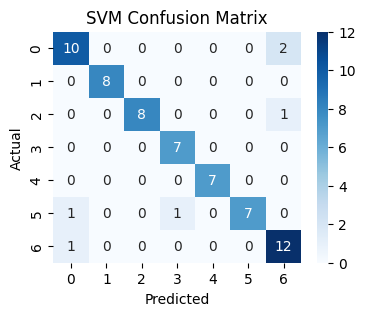

In [8]:
svm_model = svm.SVC(kernel='linear', random_state=42)
train_and_plot_model(svm_model, 'SVM')

### KNN

Accuracy: 0.8462
Precision: 0.8585
Recall: 0.8462
F1 score: 0.8443
----------------------------


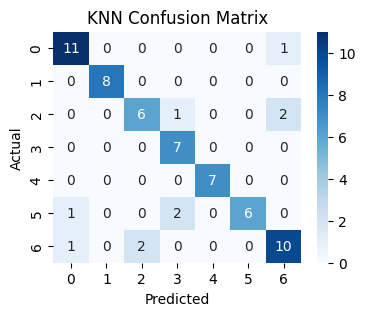

In [9]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=3)
train_and_plot_model(knn_model, 'KNN')

### Decision Tree

Accuracy: 0.7538
Precision: 0.7606
Recall: 0.7538
F1 score: 0.7540
----------------------------


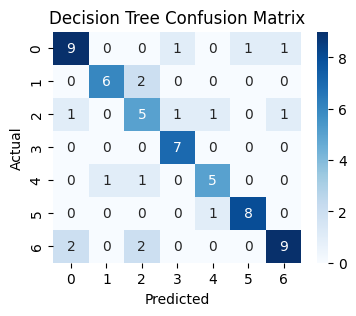

In [10]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=42)
train_and_plot_model(dt_model, 'Decision Tree')

### Naive Bayes

Accuracy: 0.7692
Precision: 0.7975
Recall: 0.7692
F1 score: 0.7720
----------------------------


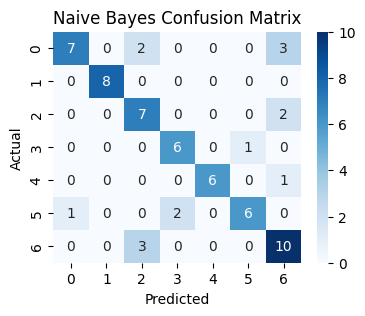

In [11]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
train_and_plot_model(nb_model, 'Naive Bayes')

### Logistic Regression

Accuracy: 0.9231
Precision: 0.9326
Recall: 0.9231
F1 score: 0.9226
----------------------------


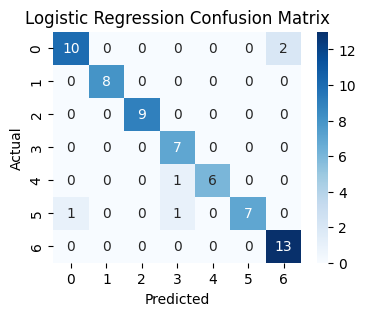

In [12]:
from sklearn.linear_model import LogisticRegression

regression_model = LogisticRegression(random_state=42)
train_and_plot_model(regression_model, 'Logistic Regression')

### Gradient Boosting

Accuracy: 0.8308
Precision: 0.8412
Recall: 0.8308
F1 score: 0.8318
----------------------------


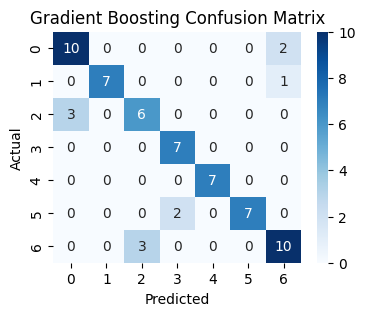

In [13]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(random_state=42)
train_and_plot_model(gb_model, 'Gradient Boosting')

### Model Comparison

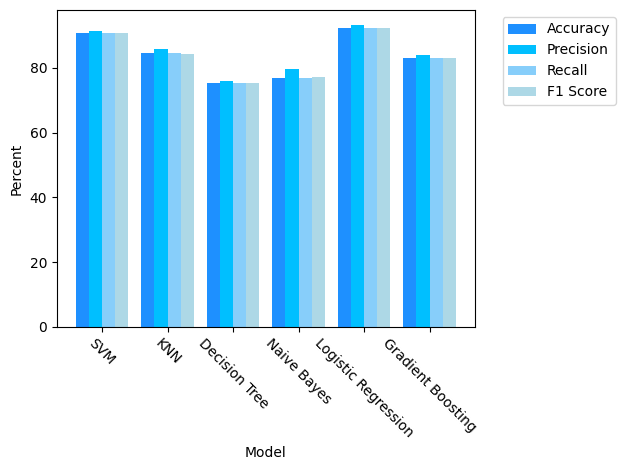

In [14]:
x = np.arange(len(models))  
width = 0.2                

plt.bar(x - 1.5*width, model_accuracies, width, label='Accuracy', color='dodgerblue')
plt.bar(x - 0.5*width, model_precisions, width, label='Precision', color='deepskyblue')
plt.bar(x + 0.5*width, model_recalls, width, label='Recall', color='lightskyblue')
plt.bar(x + 1.5*width, model_f1scores, width, label='F1 Score', color='lightblue')

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.xticks(x, labels=models, rotation=-45)
plt.xlabel('Model')
plt.ylabel('Percent')

plt.tight_layout()
plt.show()

### Volume

In [15]:
# accuracy plot
models = []
model_accuracies = []
model_precisions = []
model_recalls = []
model_f1scores = []

x = df.drop(columns=['volume', 'substance'])
y = df['volume']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

print(x_train_scaled.shape)  
print(y_train.shape)  

(258, 198)
(258,)


C:\Users\chloe\AppData\Local\Temp\ipykernel_30600\1694633448.py:8: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  x = df.drop(columns=['volume', 'substance'])


Accuracy: 0.8923
Precision: 0.8954
Recall: 0.8923
F1 score: 0.8914
----------------------------


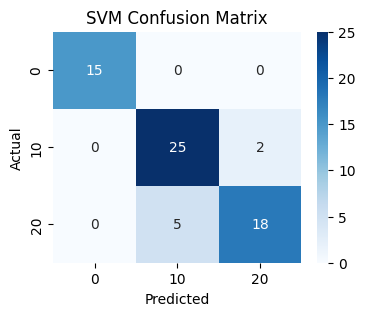

In [16]:
train_and_plot_model(svm_model, 'SVM')

Accuracy: 0.8769
Precision: 0.8758
Recall: 0.8769
F1 score: 0.8760
----------------------------


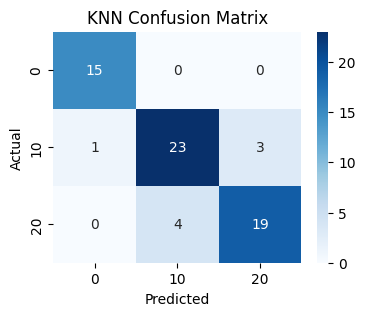

In [17]:
train_and_plot_model(knn_model, 'KNN')

Accuracy: 0.8000
Precision: 0.8123
Recall: 0.8000
F1 score: 0.8027
----------------------------


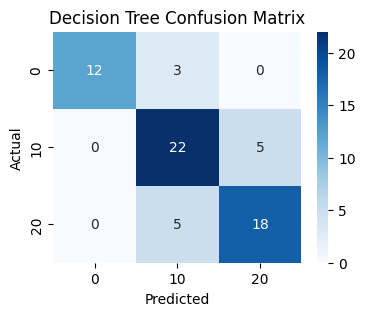

In [18]:
train_and_plot_model(dt_model, 'Decision Tree')

Accuracy: 0.7538
Precision: 0.7574
Recall: 0.7538
F1 score: 0.7541
----------------------------


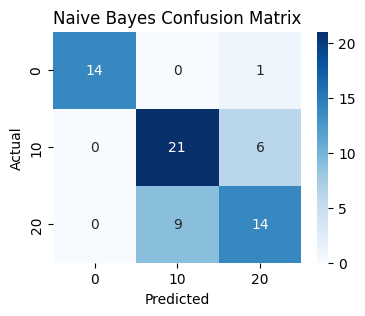

In [19]:
train_and_plot_model(nb_model, 'Naive Bayes')

Accuracy: 0.8615
Precision: 0.8738
Recall: 0.8615
F1 score: 0.8625
----------------------------


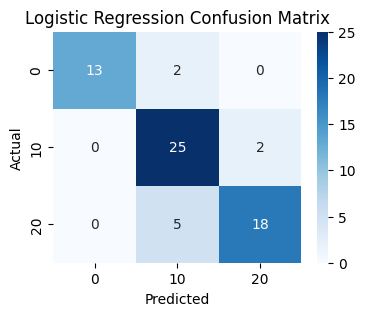

In [20]:
train_and_plot_model(regression_model, 'Logistic Regression')

Accuracy: 0.8769
Precision: 0.8801
Recall: 0.8769
F1 score: 0.8777
----------------------------


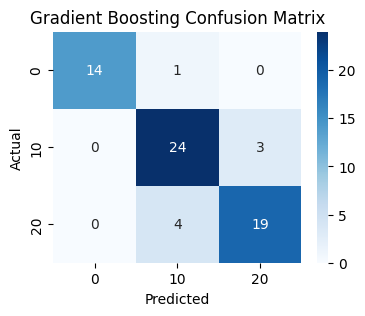

In [21]:
train_and_plot_model(gb_model, 'Gradient Boosting')

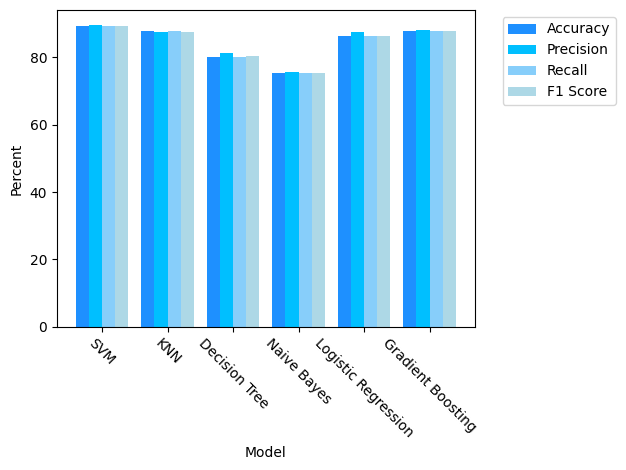

In [22]:
x = np.arange(len(models))  
width = 0.2                

plt.bar(x - 1.5*width, model_accuracies, width, label='Accuracy', color='dodgerblue')
plt.bar(x - 0.5*width, model_precisions, width, label='Precision', color='deepskyblue')
plt.bar(x + 0.5*width, model_recalls, width, label='Recall', color='lightskyblue')
plt.bar(x + 1.5*width, model_f1scores, width, label='F1 Score', color='lightblue')

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.xticks(x, labels=models, rotation=-45)
plt.xlabel('Model')
plt.ylabel('Percent')

plt.tight_layout()
plt.show()

# Multi Label Classification

In [23]:
label_names = ['Substance', 'Volume']

# accuracies
models = []
model_exact_accuracies = [] # predicts both labels right

def train_and_plot_multioutput_model(model, model_name, cm=True):
    model.fit(x_train_scaled, y_train)
    y_pred = model.predict(x_test_scaled)

    # Exact match accuracy (all labels correct)
    exact_match_accuracy = np.mean(np.all(y_test.values == y_pred, axis=1))

    # Per-label accuracy
    per_label_accuracy = (y_test == y_pred).mean(axis=0)
    average_label_accuracy = per_label_accuracy.mean()

    models.append(model_name)
    model_exact_accuracies.append(exact_match_accuracy * 100)

    print(model_name)
    print(f'Exact Match Accuracy: {exact_match_accuracy:.4f}')
    print(f'Average Per-Label Accuracy: {average_label_accuracy:.4f}')
    print(f'Per-Label Accuracies: {per_label_accuracy.values if hasattr(per_label_accuracy, "values") else per_label_accuracy}')
    print('----------------------------')

    # Confusion matrices for each label
    if cm == True:
        for i, col in enumerate(y_test.columns):
            cm = confusion_matrix(y_test.iloc[:, i], y_pred[:, i])
            plt.figure(figsize=(4, 3))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f'{model_name} Confusion Matrix, {label_names[i]}')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.show()

In [24]:
x = df.drop(columns=['volume', 'substance'])
y = df[['substance', 'volume']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

y_train = y_train.astype(int)
y_test = y_test.astype(int)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

print(x_train_scaled.shape)  
print(y_train.shape)  

(258, 198)
(258, 2)


C:\Users\chloe\AppData\Local\Temp\ipykernel_30600\437239220.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  x = df.drop(columns=['volume', 'substance'])


In [25]:
from sklearn.multioutput import MultiOutputClassifier

model = MultiOutputClassifier(svm_model)
train_and_plot_multioutput_model(model, 'SVM', cm=False)

model = MultiOutputClassifier(knn_model)
train_and_plot_multioutput_model(model, 'KNN', cm=False)

model = MultiOutputClassifier(dt_model)
train_and_plot_multioutput_model(model, 'Decision Tree', cm=False)

model = MultiOutputClassifier(nb_model)
train_and_plot_multioutput_model(model, 'Naive Bayes', cm=False)

model = MultiOutputClassifier(regression_model)
train_and_plot_multioutput_model(model, 'Logistic Regression', cm=False)

model = MultiOutputClassifier(gb_model)
train_and_plot_multioutput_model(model, 'Gradient Boosting', cm=False)

SVM
Exact Match Accuracy: 0.8000
Average Per-Label Accuracy: 0.9000
Per-Label Accuracies: [0.90769231 0.89230769]
----------------------------
KNN
Exact Match Accuracy: 0.8308
Average Per-Label Accuracy: 0.8615
Per-Label Accuracies: [0.84615385 0.87692308]
----------------------------
Decision Tree
Exact Match Accuracy: 0.6308
Average Per-Label Accuracy: 0.7769
Per-Label Accuracies: [0.75384615 0.8       ]
----------------------------
Naive Bayes
Exact Match Accuracy: 0.6154
Average Per-Label Accuracy: 0.7615
Per-Label Accuracies: [0.76923077 0.75384615]
----------------------------
Logistic Regression
Exact Match Accuracy: 0.7846
Average Per-Label Accuracy: 0.8923
Per-Label Accuracies: [0.92307692 0.86153846]
----------------------------
Gradient Boosting
Exact Match Accuracy: 0.7385
Average Per-Label Accuracy: 0.8538
Per-Label Accuracies: [0.83076923 0.87692308]
----------------------------


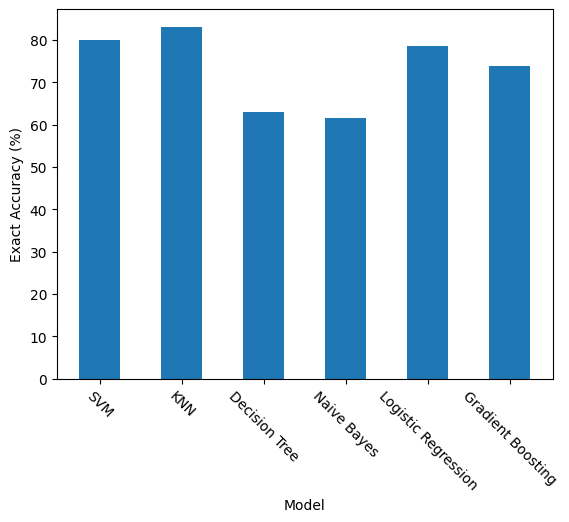

In [26]:
plt.bar(models, model_exact_accuracies, width=0.5)

plt.xticks(rotation=-45)
plt.xlabel('Model')
plt.ylabel('Exact Accuracy (%)')

plt.show()

In [27]:
import csv

with open('multioutput_rectified_accuracies.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(model_exact_accuracies)

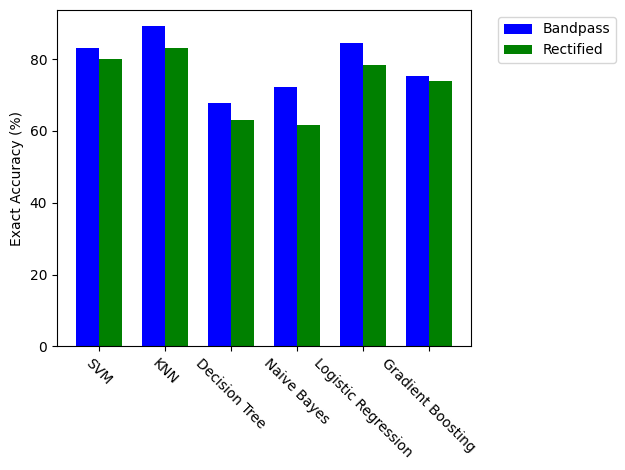

In [28]:
bandpass_accuracies_df = pd.read_csv('multioutput_bandpass_accuracies.csv', header=None)
bandpass_accuracies = bandpass_accuracies_df.iloc[0].tolist()

x = np.arange(len(models))  # [0, 1, 2]
width = 0.35  # width of each bar

# Plot bars side by side
plt.bar(x - width/2, bandpass_accuracies, width, label='Bandpass', color='blue')
plt.bar(x + width/2, model_exact_accuracies, width, label='Rectified', color='green')

# Add labels
plt.xticks(x, models, rotation=-45)
plt.ylabel('Exact Accuracy (%)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()